In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [2]:
file_path = './lendingclub_cleaned.csv' 
df_cleaned = pd.read_csv(file_path)


In [3]:
# Split the data into training and testing sets
X = df_cleaned.drop(columns=['default','loan_status'])
y = df_cleaned['default']

splite into training data , test data , validation data

In [4]:
# 20% of the data will be used for testing
X_train_val, X_test, y_train_val, y_test = train_test_split( X, y, test_size=0.2, stratify=y, random_state=42)
# 80% of the training data will be used for training and 30% for validation
X_train, X_val, y_train, y_val = train_test_split( X_train_val, y_train_val, test_size=0.3, stratify=y_train_val, random_state=42)

print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

Train: (766956, 95), Validation: (328696, 95), Test: (273914, 95)


SMOTE

In [5]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
# 检查每类样本数
import pandas as pd
print("SMOTE 后的类别分布：")
print(pd.Series(y_train_resampled).value_counts())

SMOTE 后的类别分布：
default
0.0    604093
1.0    604093
Name: count, dtype: int64


In [6]:
df_cleaned[['default']].value_counts()

default
0.0        1078739
1.0         290827
Name: count, dtype: int64

standardscale

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


LDA

X_train_lda: (1208186, 1), X_val_lda: (328696, 1), X_test_lda: (273914, 1)


<Axes: xlabel='LD1', ylabel='default'>

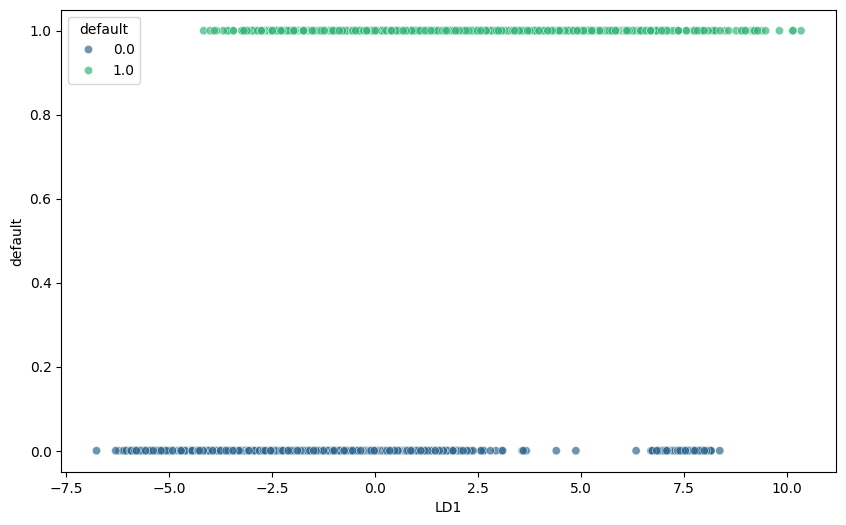

In [12]:
# using Linear Discriminant Analysis (LDA) for dimensionality reduction
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train_resampled)
X_val_lda = lda.transform(X_val_scaled)
X_test_lda = lda.transform(X_test_scaled)


lda_df = pd.DataFrame(X_train_lda, columns=['LD1'])
lda_df['default'] = y_train_resampled
print(f"X_train_lda: {X_train_lda.shape}, X_val_lda: {X_val_lda.shape}, X_test_lda: {X_test_lda.shape}")

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='default', hue='default', palette='viridis', alpha=0.7)



In [ ]:
#calculate the contribution of each feature to the LDA projection

feature_names = X.columns if isinstance(X_train, pd.DataFrame) else [f'Feature_{i}' for i in range(X_train.shape[1])]


lda_coeff_df = pd.DataFrame(
    np.abs(lda.scalings_),  # 取绝对值，忽略方向
    index=feature_names,
    columns=[f'LD{i+1}' for i in range(lda.scalings_.shape[1])]
)

lda_coeff_df['Total_Contribution'] = lda_coeff_df.sum(axis=1)


top_features = lda_coeff_df.sort_values(by='Total_Contribution', ascending=False).head(30)



In [19]:
lda_coeffs = np.abs(lda.coef_[0])
top20_indices = np.argsort(lda_coeffs)[-30:]
lda_top20_features = X_train.select_dtypes(include=np.number).columns[top20_indices].tolist()
print("LDA Top 20 Features:", lda_top20_features)

supplement_features = [
    'avg_account_balance', 'monthly_payment_ratio', 'past_due_amount_sum',
    'repayment_frequency', 'age', 'education_level', 'marital_status', 'employment_length'
]

all_features = lda_top20_features + supplement_features

selected_features = [f for f in lda_top20_features + supplement_features if f in df_cleaned.columns]


X_train_model = X_train[selected_features].copy()
X_val_model = X_val[selected_features].copy()
X_test_model = X_test[selected_features].copy()



LDA Top 20 Features: ['num_actv_rev_tl', 'num_bc_sats', 'last_fico_range_low', 'num_rev_tl_bal_gt_0', 'mo_sin_old_rev_tl_op', 'total_acc', 'last_credit_pull_d_year', 'dti', 'bc_open_to_buy', 'issue_d_month', 'total_rec_late_fee', 'last_pymnt_d_month', 'loan_amnt', 'term', 'int_rate', 'total_rec_int', 'installment', 'last_pymnt_amnt', 'last_pymnt_d_year', 'issue_d_year', 'total_pymnt', 'funded_amnt_inv', 'last_fico_range_high', 'total_pymnt_inv', 'funded_amnt', 'total_rec_prncp', 'out_prncp_inv', 'out_prncp', 'fico_range_low', 'fico_range_high']


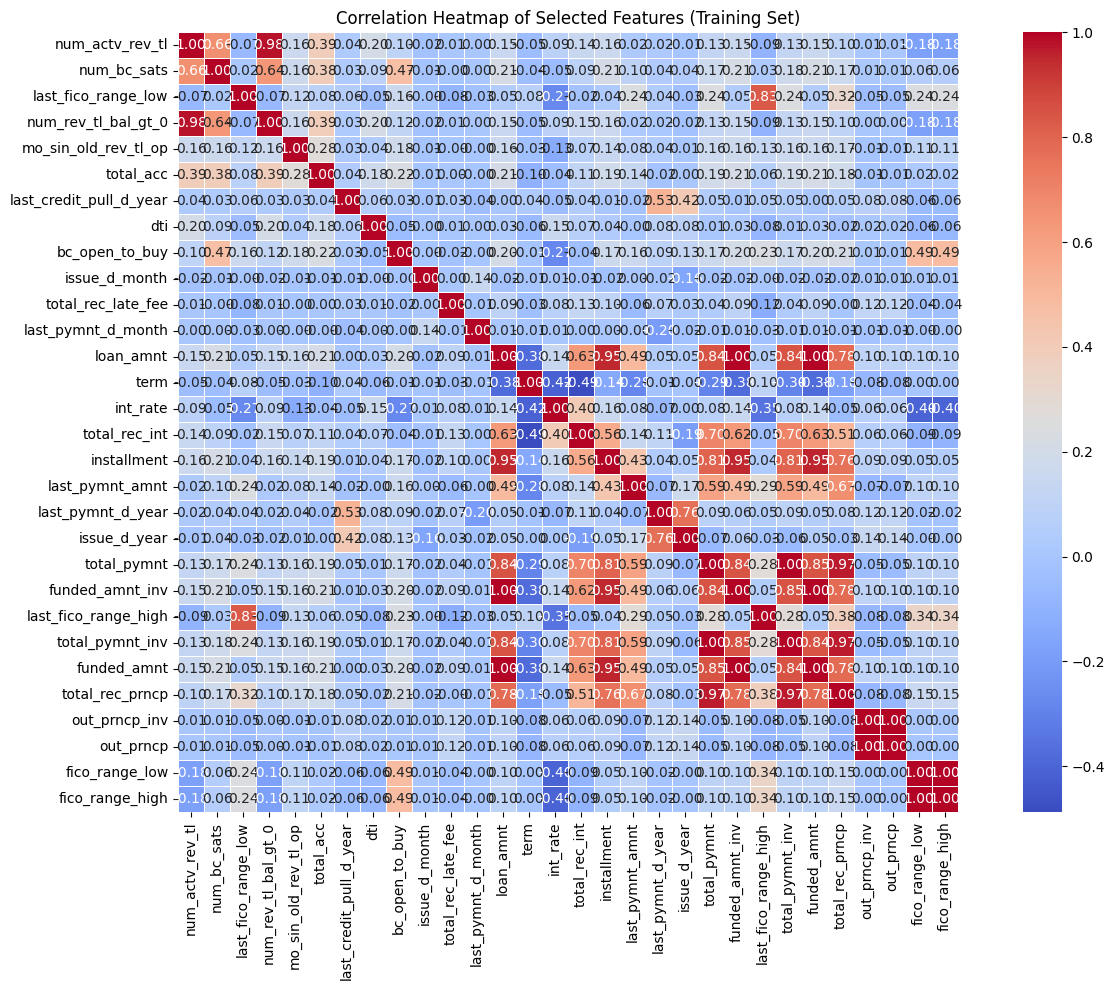

In [20]:
# high correlation matrix
X_corr = pd.DataFrame(X_train_model, columns=selected_features)

correlation_matrix = X_corr.corr(method='pearson')

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5)
plt.title("Correlation Heatmap of Selected Features (Training Set)")
plt.tight_layout()
plt.show()



In [21]:

upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))


high_corr_pairs = [(col, row, upper.loc[row, col])
                   for col in upper.columns
                   for row in upper.index
                   if abs(upper.loc[row, col]) > 0.85]

# Print high correlation pairs
for f1, f2, corr_val in high_corr_pairs:
    print(f"{f1} vs {f2} --> correlation = {corr_val:.2f}")


num_rev_tl_bal_gt_0 vs num_actv_rev_tl --> correlation = 0.98
installment vs loan_amnt --> correlation = 0.95
funded_amnt_inv vs loan_amnt --> correlation = 1.00
funded_amnt_inv vs installment --> correlation = 0.95
total_pymnt_inv vs total_pymnt --> correlation = 1.00
funded_amnt vs loan_amnt --> correlation = 1.00
funded_amnt vs installment --> correlation = 0.95
funded_amnt vs funded_amnt_inv --> correlation = 1.00
total_rec_prncp vs total_pymnt --> correlation = 0.97
total_rec_prncp vs total_pymnt_inv --> correlation = 0.97
out_prncp vs out_prncp_inv --> correlation = 1.00
fico_range_high vs fico_range_low --> correlation = 1.00


In [22]:
columns_to_drop = [
    'num_rev_tl_bal_gt_0',
    'installment',
    'funded_amnt_inv',
    'funded_amnt',
    'total_pymnt_inv',
    'total_rec_prncp',
    'out_prncp_inv',
    'fico_range_low'
]

final_features = [f for f in selected_features if f not in columns_to_drop]
print("Removed due to high correlation:", columns_to_drop)
print("Remaining features for model:", final_features)

Removed due to high correlation: ['num_rev_tl_bal_gt_0', 'installment', 'funded_amnt_inv', 'funded_amnt', 'total_pymnt_inv', 'total_rec_prncp', 'out_prncp_inv', 'fico_range_low']
Remaining features for model: ['num_actv_rev_tl', 'num_bc_sats', 'last_fico_range_low', 'mo_sin_old_rev_tl_op', 'total_acc', 'last_credit_pull_d_year', 'dti', 'bc_open_to_buy', 'issue_d_month', 'total_rec_late_fee', 'last_pymnt_d_month', 'loan_amnt', 'term', 'int_rate', 'total_rec_int', 'last_pymnt_amnt', 'last_pymnt_d_year', 'issue_d_year', 'total_pymnt', 'last_fico_range_high', 'out_prncp', 'fico_range_high']


In [28]:

X_train_reduced = X_train_model[final_features] 
X_val_reduced   = X_val_model[final_features]
X_test_reduced  = X_test_model[final_features]

X_train_scaled = scaler.fit_transform(X_train_reduced)
X_val_scaled   = scaler.transform(X_val_reduced)
X_test_scaled  = scaler.transform(X_test_reduced)


X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=final_features)
X_val_scaled_df   = pd.DataFrame(X_val_scaled, columns=final_features)
X_test_scaled_df  = pd.DataFrame(X_test_scaled, columns=final_features)



MOdel Training

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    classification_report
)
import matplotlib.pyplot as plt

In [47]:
from sklearn.linear_model import LogisticRegression
# Train logistic regression model
model = LogisticRegression(class_weight='balanced', penalty='elasticnet', solver='saga', l1_ratio=0.5)
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_val = model.predict(X_val_scaled)
y_prob_val = model.predict_proba(X_val_scaled)[:, 1]  # probabilities for the positive class

# Evaluation metrics
accuracy = accuracy_score(y_val, y_pred_val)
precision = precision_score(y_val, y_pred_val, zero_division=0)
recall = recall_score(y_val, y_pred_val)
f1 = f1_score(y_val, y_pred_val)
auc = roc_auc_score(y_val, y_prob_val)

# Print results
print("Logistic Regression Performance Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_pred_val))

# test set evaluation
y_pred_test = model.predict(X_test_scaled)
y_prob_test = model.predict_proba(X_test_scaled)[:, 1]  # probabilities for the positive class
test_accuracy = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, zero_division=0)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_auc = roc_auc_score(y_test, y_prob_test)

print("\nTest Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall:    {test_recall:.4f}")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")





# # Plot ROC Curve
# fpr, tpr, _ = roc_curve(y_val, y_prob_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate (Recall)')
# plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.tight_layout()
# plt.show()

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic Regression Performance Metrics:
Accuracy:  0.9930
Precision: 0.9804
Recall:    0.9866
F1-Score:  0.9835
AUC-ROC:   0.9986

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    258898
         1.0       0.98      0.99      0.98     69798

    accuracy                           0.99    328696
   macro avg       0.99      0.99      0.99    328696
weighted avg       0.99      0.99      0.99    328696


Test Set Performance Metrics:
Accuracy:  0.9928
Precision: 0.9802
Recall:    0.9861
F1-Score:  0.9832
AUC-ROC:   0.9985


In [48]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 1. training
dt_model = DecisionTreeClassifier(max_depth=7, min_samples_split=15, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

# 2. prediction
y_pred_dt_val = dt_model.predict(X_val_scaled)  # Use X_val_scaled for predictions
y_pred_proba_dt_val = dt_model.predict_proba(X_val_scaled)[:, 1]  # Use X_test for probabilities


# 3. evaluate
accuracy_dt = accuracy_score(y_val, y_pred_dt_val)
precision_dt = precision_score(y_val, y_pred_dt_val)
recall_dt = recall_score(y_val, y_pred_dt_val)
f1_dt = f1_score(y_val, y_pred_dt_val)
auc_dt = roc_auc_score(y_val, y_pred_proba_dt_val)

# 4. print
print("Decision Tree Performance Metrics:")
print(f"Accuracy:  {accuracy_dt:.4f}")
print(f"Precision: {precision_dt:.4f}")
print(f"Recall:    {recall_dt:.4f}")
print(f"F1-Score:  {f1_dt:.4f}")
print(f"AUC-ROC:   {auc_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_dt_val))

# # 5.  ROC 
# fpr_dt, tpr_dt, _ = roc_curve(y_val, y_pred_proba_dt_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', color='green')
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Decision Tree')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# 6. evaluation
y_pred_dt_test = dt_model.predict(X_test_scaled)  # Use X_test_scaled for predictions
y_pred_proba_dt_test = dt_model.predict_proba(X_test_scaled)[:, 1]  # Use X_test for probabilities

test_accuracy_dt = accuracy_score(y_test, y_pred_dt_test)
test_precision_dt = precision_score(y_test, y_pred_dt_test)
test_recall_dt = recall_score(y_test, y_pred_dt_test)
test_f1_dt = f1_score(y_test, y_pred_dt_test)
test_auc_dt = roc_auc_score(y_test, y_pred_proba_dt_test)
print("\nDecision Tree Test Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy_dt:.4f}")
print(f"Precision: {test_precision_dt:.4f}")
print(f"Recall:    {test_recall_dt:.4f}")
print(f"F1-Score:  {test_f1_dt:.4f}")
print(f"AUC-ROC:   {test_auc_dt:.4f}")



Decision Tree Performance Metrics:
Accuracy:  0.9560
Precision: 0.8531
Recall:    0.9579
F1-Score:  0.9025
AUC-ROC:   0.9873

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    258898
         1.0       0.85      0.96      0.90     69798

    accuracy                           0.96    328696
   macro avg       0.92      0.96      0.94    328696
weighted avg       0.96      0.96      0.96    328696


Decision Tree Test Set Performance Metrics:
Accuracy:  0.9556
Precision: 0.8520
Recall:    0.9570
F1-Score:  0.9014
AUC-ROC:   0.9870


In [49]:
# xgboost
# 1. XGBoost training
from xgboost import XGBClassifier
xgb_model = XGBClassifier( eval_metric='auc')
xgb_model.fit(X_train_scaled, y_train)
# 2. prediction
y_pred_xgb_val = xgb_model.predict(X_val_scaled)
y_pred_proba_xgb_val = xgb_model.predict_proba(X_val_scaled)[:, 1]
# 3. evaluation
accuracy_xgb = accuracy_score(y_val, y_pred_xgb_val)
precision_xgb = precision_score(y_val, y_pred_xgb_val)
recall_xgb = recall_score(y_val, y_pred_xgb_val)
f1_xgb = f1_score(y_val, y_pred_xgb_val)
auc_xgb = roc_auc_score(y_val, y_pred_proba_xgb_val)
# 4. print
print("XGBoost Performance Metrics:")
print(f"Accuracy:  {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall:    {recall_xgb:.4f}")
print(f"F1-Score:  {f1_xgb:.4f}")
print(f"AUC-ROC:   {auc_xgb:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_xgb_val))

#  5. 绘制 ROC curve
# fpr_xgb, tpr_xgb, _ = roc_curve(y_val, y_pred_proba_xgb_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', color='orange')
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - XGBoost')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# 6. evaluation on test set
y_pred_xgb_test = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb_test = xgb_model.predict_proba(X_test_scaled)[:, 1]
# Calculate performance metrics for the test set
test_accuracy_xgb = accuracy_score(y_test, y_pred_xgb_test)
test_precision_xgb = precision_score(y_test, y_pred_xgb_test)
test_recall_xgb = recall_score(y_test, y_pred_xgb_test)
test_f1_xgb = f1_score(y_test, y_pred_xgb_test)
test_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb_test)
print("\nXGBoost Test Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy_xgb:.4f}")
print(f"Precision: {test_precision_xgb:.4f}")
print(f"Recall:    {test_recall_xgb:.4f}")
print(f"F1-Score:  {test_f1_xgb:.4f}")
print(f"AUC-ROC:   {test_auc_xgb:.4f}")


XGBoost Performance Metrics:
Accuracy:  0.9970
Precision: 0.9976
Recall:    0.9885
F1-Score:  0.9930
AUC-ROC:   0.9997

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    258898
         1.0       1.00      0.99      0.99     69798

    accuracy                           1.00    328696
   macro avg       1.00      0.99      1.00    328696
weighted avg       1.00      1.00      1.00    328696


XGBoost Test Set Performance Metrics:
Accuracy:  0.9971
Precision: 0.9978
Recall:    0.9885
F1-Score:  0.9931
AUC-ROC:   0.9997


In [50]:
# svm
from sklearn.svm import SVC
# 1. SVM training
svm_model = SVC(probability=True, random_state=42, class_weight='balanced')
# only choosing 5% for smaller case
X_train_sampled, y_train_sampled = X_train_scaled[:int(0.05 * len(X_train_scaled))], y_train[:int(0.05 * len(y_train))]
svm_model.fit(X_train_sampled, y_train_sampled)

# 2. model prediction
y_pred_svm_val = svm_model.predict(X_val_scaled)
y_pred_proba_svm_val = svm_model.predict_proba(X_val_scaled)[:, 1]
# 3. evaluation
accuracy_svm = accuracy_score(y_val, y_pred_svm_val)
precision_svm = precision_score(y_val, y_pred_svm_val, average='macro')  # Fixed average parameter
recall_svm = recall_score(y_val, y_pred_svm_val, average='macro')        # Fixed average parameter
f1_svm = f1_score(y_val, y_pred_svm_val, average='macro')                # Fixed average parameter
auc_svm = roc_auc_score(y_val, y_pred_proba_svm_val, multi_class='ovr')  # Adjusted for multiclass
# 4. print
print("SVM Performance Metrics:")
print(f"Accuracy:  {accuracy_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall:    {recall_svm:.4f}")
print(f"F1-Score:  {f1_svm:.4f}")
print(f"AUC-ROC:   {auc_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_svm_val))

# 5.ROC curve
# fpr_svm, tpr_svm, _ = roc_curve(y_val, y_pred_proba_svm_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})', color='purple')
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - SVM')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# 6. evaluation
y_pred_svm_test = svm_model.predict(X_test_scaled)
y_pred_proba_svm_test = svm_model.predict_proba(X_test_scaled)[:, 1]
# training on test
test_accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
test_precision_svm = precision_score(y_test, y_pred_svm_test, average='macro')  # Fixed average parameter
test_recall_svm = recall_score(y_test, y_pred_svm_test, average='macro')        # Fixed average parameter
test_f1_svm = f1_score(y_test, y_pred_svm_test, average='macro')                # Fixed average parameter
test_auc_svm = roc_auc_score(y_test, y_pred_proba_svm_test, multi_class='ovr')  # Adjusted for multiclass
print("\nSVM Test Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy_svm:.4f}")
print(f"Precision: {test_precision_svm:.4f}")
print(f"Recall:    {test_recall_svm:.4f}")
print(f"F1-Score:  {test_f1_svm:.4f}")
print(f"AUC-ROC:   {test_auc_svm:.4f}")


SVM Performance Metrics:
Accuracy:  0.9871
Precision: 0.9774
Recall:    0.9844
F1-Score:  0.9809
AUC-ROC:   0.9985

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99    258898
         1.0       0.96      0.98      0.97     69798

    accuracy                           0.99    328696
   macro avg       0.98      0.98      0.98    328696
weighted avg       0.99      0.99      0.99    328696


SVM Test Set Performance Metrics:
Accuracy:  0.9873
Precision: 0.9779
Recall:    0.9844
F1-Score:  0.9811
AUC-ROC:   0.9985


In [51]:
#random forest
from sklearn.ensemble import RandomForestClassifier
# 1. training
rf_model = RandomForestClassifier(random_state=42, n_estimators=500, class_weight='balanced', max_depth=8, min_samples_split=15)
rf_model.fit(X_train_scaled, y_train)
# 2. prediction
y_pred_rf_val = rf_model.predict(X_val_scaled)
y_pred_proba_rf_val = rf_model.predict_proba(X_val_scaled)[:, 1]
# 3. evaluation
accuracy_rf = accuracy_score(y_val, y_pred_rf_val)
precision_rf = precision_score(y_val, y_pred_rf_val)
recall_rf = recall_score(y_val, y_pred_rf_val)
f1_rf = f1_score(y_val, y_pred_rf_val)
auc_rf = roc_auc_score(y_val, y_pred_proba_rf_val)
# 4. print
print("Random Forest Performance Metrics:")
print(f"Accuracy:  {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall:    {recall_rf:.4f}")
print(f"F1-Score:  {f1_rf:.4f}")
print(f"AUC-ROC:   {auc_rf:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_rf_val))

# 5.  ROC curve
# fpr_rf, tpr_rf, _ = roc_curve(y_val, y_pred_proba_rf_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='brown')
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Random Forest')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# 6. model evaluation on test set
y_pred_rf_test = rf_model.predict(X_test_scaled)
y_pred_proba_rf_test = rf_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy_rf = accuracy_score(y_test, y_pred_rf_test)
test_precision_rf = precision_score(y_test, y_pred_rf_test)
test_recall_rf = recall_score(y_test, y_pred_rf_test)
test_f1_rf = f1_score(y_test, y_pred_rf_test)
test_auc_rf = roc_auc_score(y_test, y_pred_proba_rf_test)
print("\nRandom Forest Test Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy_rf:.4f}")
print(f"Precision: {test_precision_rf:.4f}")
print(f"Recall:    {test_recall_rf:.4f}")
print(f"F1-Score:  {test_f1_rf:.4f}")
print(f"AUC-ROC:   {test_auc_rf:.4f}")


Random Forest Performance Metrics:
Accuracy:  0.9506
Precision: 0.8284
Recall:    0.9676
F1-Score:  0.8926
AUC-ROC:   0.9943

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97    258898
         1.0       0.83      0.97      0.89     69798

    accuracy                           0.95    328696
   macro avg       0.91      0.96      0.93    328696
weighted avg       0.96      0.95      0.95    328696


Random Forest Test Set Performance Metrics:
Accuracy:  0.9499
Precision: 0.8264
Recall:    0.9672
F1-Score:  0.8913
AUC-ROC:   0.9943


In [53]:
# Neural Network
from sklearn.neural_network import MLPClassifier
# 1. training
# nn_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
nn_model = MLPClassifier(hidden_layer_sizes=(200, 50), max_iter=1000, random_state=42)
nn_model.fit(X_train_scaled, y_train)
# 2. model prediction
y_pred_nn_val = nn_model.predict(X_val_scaled)
y_pred_proba_nn_val = nn_model.predict_proba(X_val_scaled)[:, 1]
# 3. evaluation
accuracy_nn = accuracy_score(y_val, y_pred_nn_val)
precision_nn = precision_score(y_val, y_pred_nn_val)
recall_nn = recall_score(y_val, y_pred_nn_val)
f1_nn = f1_score(y_val, y_pred_nn_val)
auc_nn = roc_auc_score(y_val, y_pred_proba_nn_val)
# 4. print
print("Neural Network Performance Metrics:")
print(f"Accuracy:  {accuracy_nn:.4f}")
print(f"Precision: {precision_nn:.4f}")
print(f"Recall:    {recall_nn:.4f}")
print(f"F1-Score:  {f1_nn:.4f}")
print(f"AUC-ROC:   {auc_nn:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred_nn_val))

#  5.  ROC curve
# fpr_nn, tpr_nn, _ = roc_curve(y_val, y_pred_proba_nn_val)
# plt.figure(figsize=(8, 6))
# plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', color='cyan')
# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve - Neural Network')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

# 6. evaluation on test
y_pred_nn_test = nn_model.predict(X_test_scaled)
y_pred_proba_nn_test = nn_model.predict_proba(X_test_scaled)[:, 1]

test_accuracy_nn = accuracy_score(y_test, y_pred_nn_test)
test_precision_nn = precision_score(y_test, y_pred_nn_test)
test_recall_nn = recall_score(y_test, y_pred_nn_test)
test_f1_nn = f1_score(y_test, y_pred_nn_test)
test_auc_nn = roc_auc_score(y_test, y_pred_proba_nn_test)
print("\nNeural Network Test Set Performance Metrics:")
print(f"Accuracy:  {test_accuracy_nn:.4f}")
print(f"Precision: {test_precision_nn:.4f}")
print(f"Recall:    {test_recall_nn:.4f}")
print(f"F1-Score:  {test_f1_nn:.4f}")
print(f"AUC-ROC:   {test_auc_nn:.4f}")

Neural Network Performance Metrics:
Accuracy:  0.9982
Precision: 0.9983
Recall:    0.9934
F1-Score:  0.9958
AUC-ROC:   0.9995

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    258898
         1.0       1.00      0.99      1.00     69798

    accuracy                           1.00    328696
   macro avg       1.00      1.00      1.00    328696
weighted avg       1.00      1.00      1.00    328696


Neural Network Test Set Performance Metrics:
Accuracy:  0.9983
Precision: 0.9982
Recall:    0.9936
F1-Score:  0.9959
AUC-ROC:   0.9995



Model Performance Comparison:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Model                                                                 
Logistic Regression  0.992966   0.980382  0.986619  0.983490  0.998588
Decision Tree        0.956048   0.853134  0.957921  0.902496  0.987296
XGBoost              0.997046   0.997585  0.988481  0.993012  0.999693
SVM                  0.987101   0.977430  0.984392  0.980859  0.998460
Random Forest        0.950562   0.828411  0.967607  0.892615  0.994275
Neural Network       0.998235   0.998258  0.993424  0.995835  0.999499


<Figure size 1200x800 with 0 Axes>

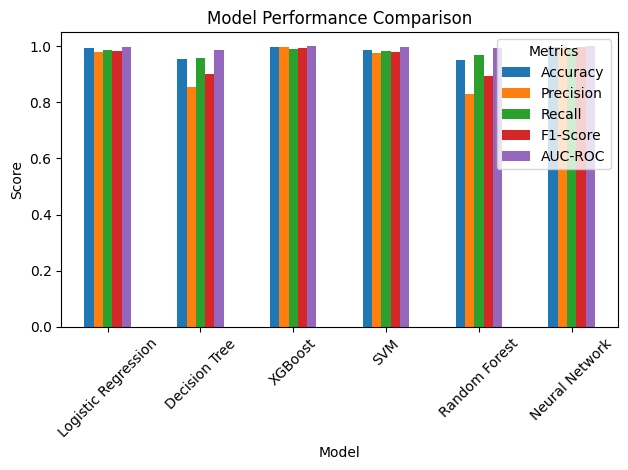

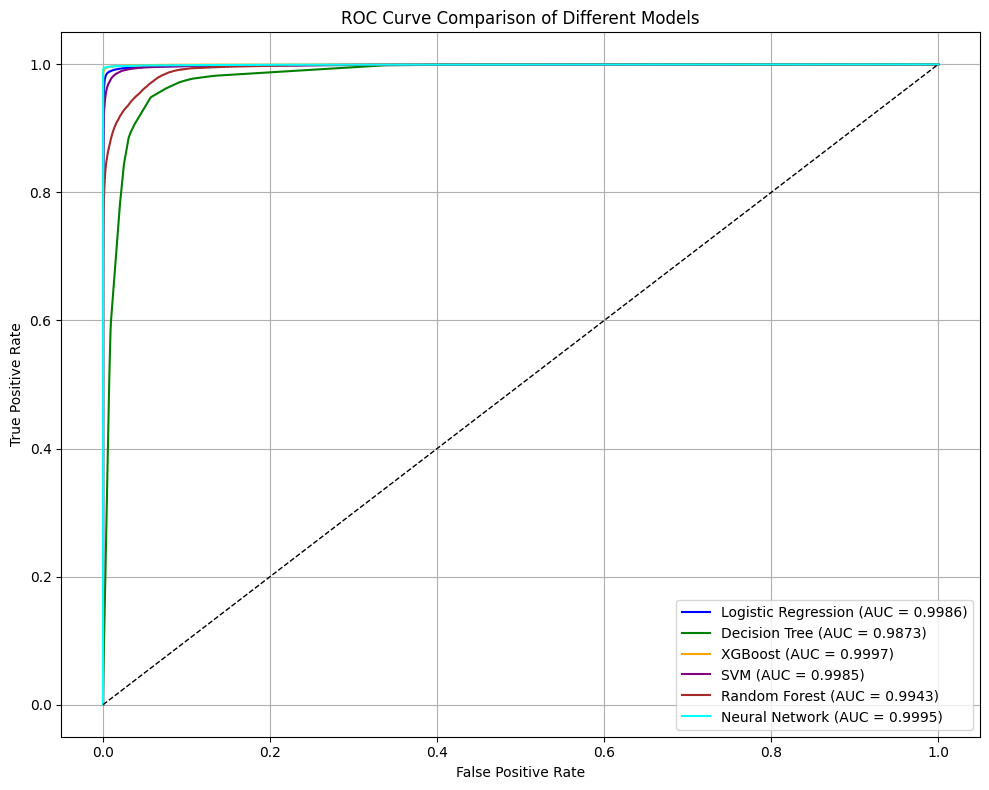

In [54]:
# model comparation
import pandas as pd

results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'SVM', 'Random Forest', 'Neural Network'],
    'Accuracy': [accuracy, accuracy_dt, accuracy_xgb, accuracy_svm, accuracy_rf, accuracy_nn],
    'Precision': [precision, precision_dt, precision_xgb, precision_svm, precision_rf, precision_nn],
    'Recall': [recall, recall_dt, recall_xgb, recall_svm, recall_rf, recall_nn],
    'F1-Score': [f1, f1_dt, f1_xgb, f1_svm, f1_rf, f1_nn],
    'AUC-ROC': [auc, auc_dt, auc_xgb, auc_svm, auc_rf, auc_nn]
})

results.set_index('Model', inplace=True)
print("\nModel Performance Comparison:")
print(results)

# visualization
plt.figure(figsize=(12, 8))
results[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(kind='bar', rot=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
# save
results = results.round(4)
# results.to_csv('model_performance_comparison.csv')
plt.show()

#summary ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})', color='blue')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', color='orange')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})', color='purple')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='brown')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', color='cyan')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
# plt.savefig('roc_curve_comparison.png')



Model Performance Comparison:
                     Accuracy  Precision    Recall  F1-Score   AUC-ROC
Model                                                                 
Logistic Regression  0.992834   0.980244  0.986126  0.983176  0.998531
Decision Tree        0.955566   0.852026  0.956951  0.901445  0.986994
XGBoost              0.997101   0.997796  0.988533  0.993143  0.999692
SVM                  0.987281   0.977887  0.984442  0.981118  0.998492
Random Forest        0.949882   0.826395  0.967163  0.891255  0.994250
Neural Network       0.998266   0.998221  0.993605  0.995907  0.999511


<Figure size 1200x800 with 0 Axes>

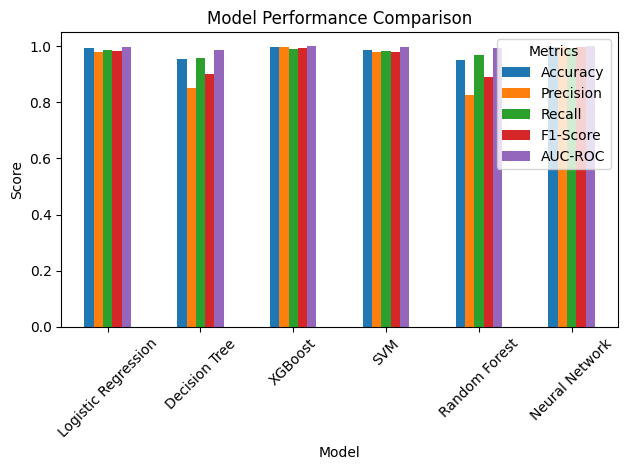

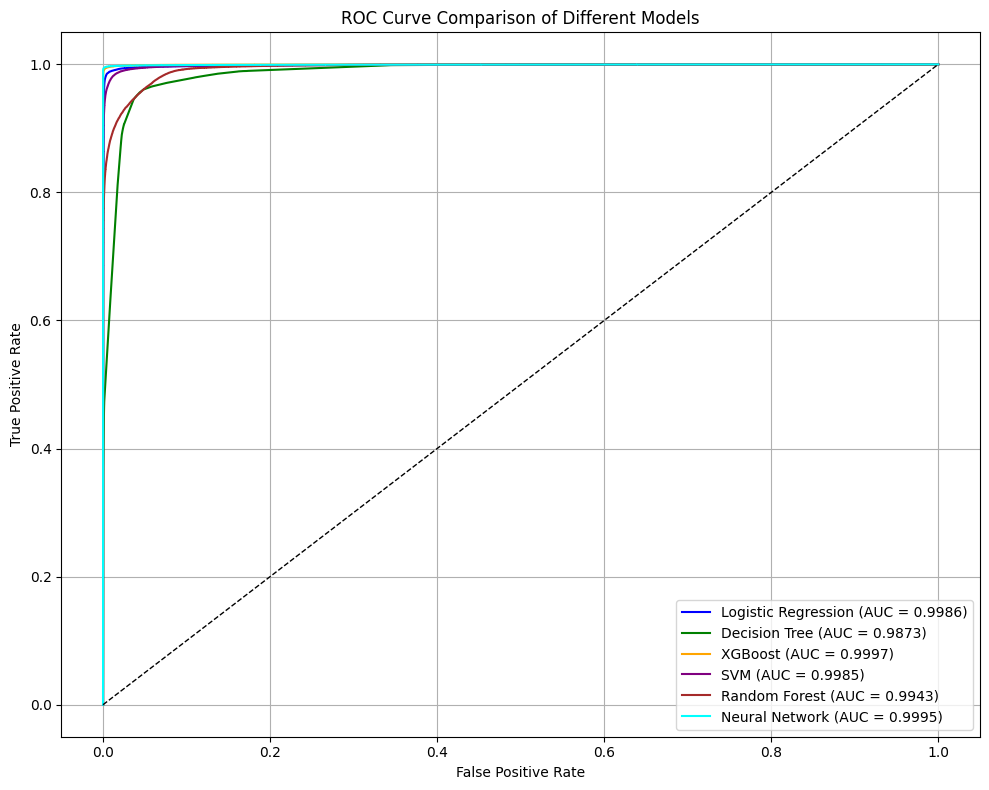

In [56]:
# re-test set evaluation 
# 
results_test = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'XGBoost', 'SVM', 'Random Forest', 'Neural Network'],
    'Accuracy': [test_accuracy, test_accuracy_dt, test_accuracy_xgb,test_accuracy_svm, test_accuracy_rf, test_accuracy_nn],
    'Precision': [test_precision, test_precision_dt, test_precision_xgb, test_precision_svm, test_precision_rf, test_precision_nn],
    'Recall': [test_recall, test_recall_dt, test_recall_xgb, test_recall_svm, test_recall_rf, test_recall_nn],
    'F1-Score': [test_f1, test_f1_dt, test_f1_xgb, test_f1_svm, test_f1_rf, test_f1_nn],
    'AUC-ROC': [test_auc, test_auc_dt, test_auc_xgb, test_auc_svm, test_auc_rf, test_auc_nn]
})

results_test.set_index('Model', inplace=True)

print("\nModel Performance Comparison:")
print(results_test)

plt.figure(figsize=(12, 8))
results_test[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(kind='bar', rot=45)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
# save
results_test = results_test.round(4)
results.to_csv('model_performance_comparison.csv')
plt.show()

# Plot ROC Curve for all models
fpr, tpr, _ = roc_curve(y_test, y_prob_test)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb_test)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_proba_svm_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf_test)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_proba_nn_test)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {auc:.4f})', color='blue')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.4f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.4f})', color='orange')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {auc_svm:.4f})', color='purple')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='brown')
plt.plot(fpr_nn, tpr_nn, label=f'Neural Network (AUC = {auc_nn:.4f})', color='cyan')
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison of Different Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('roc_curve_comparison.png')

optimized result

 97%|=================== | 531459/547828 [00:12<00:00]       

Top 10 Features from Decision Tree SHAP:
 ['last_pymnt_amnt', 'last_fico_range_low', 'total_pymnt', 'term', 'loan_amnt', 'out_prncp', 'issue_d_year', 'total_rec_late_fee', 'last_pymnt_d_year']

Final Decision Tree (Top 10 Features) Performance:
Accuracy:  0.9611
Precision: 0.8673
Recall:    0.9646
F1-Score:  0.9134
AUC-ROC:   0.9906

Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.96      0.97    215748
         1.0       0.87      0.96      0.91     58166

    accuracy                           0.96    273914
   macro avg       0.93      0.96      0.94    273914
weighted avg       0.96      0.96      0.96    273914



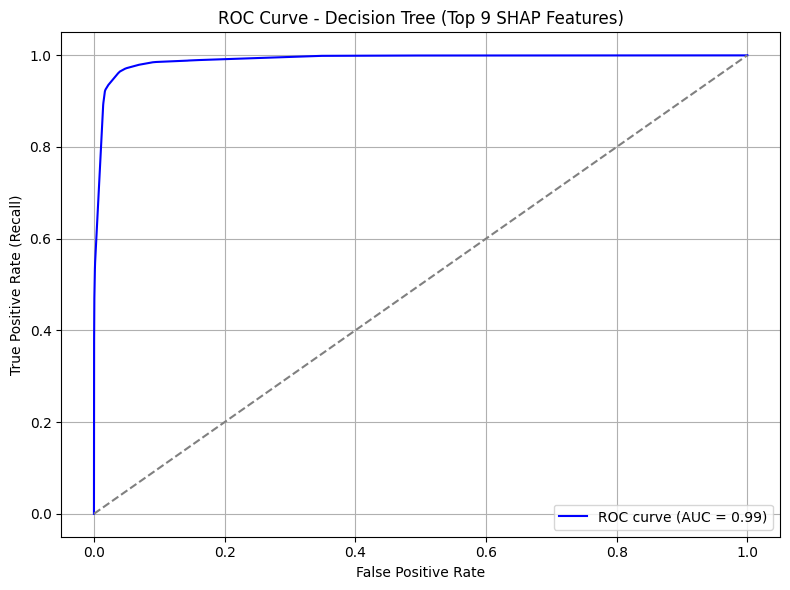

In [86]:

import shap


# reanalysis with SHAP on decision tree
dt_model = DecisionTreeClassifier(max_depth=7, min_samples_split=15, class_weight='balanced')
dt_model.fit(X_train_scaled, y_train)

explainer_dt = shap.Explainer(dt_model, X_train_scaled)
shap_values_dt = explainer_dt(X_test_scaled)

# get the mean absolute SHAP values for each feature
shap_array = np.abs(shap_values_dt.values[:, :, 0]).mean(axis=0)  
feature_importance_dt = pd.DataFrame({
    'feature': X_train_scaled_df.columns,
    'mean_abs_shap': shap_array
}).sort_values(by='mean_abs_shap', ascending=False)

# select top 19
top_10_features_dt = feature_importance_dt['feature'].head(9).tolist()
print("Top 10 Features from Decision Tree SHAP:\n", top_10_features_dt) # top 9 finally


feature_indices = [X_train_scaled_df.columns.get_loc(f) for f in top_10_features_dt]


X_train_top10 = X_train_scaled[:, feature_indices]
X_test_top10 = X_test_scaled[:, feature_indices]


final_model = DecisionTreeClassifier(max_depth=8, min_samples_split=15, class_weight='balanced')

final_model.fit(X_train_top10, y_train)

# model prediction
y_pred = final_model.predict(X_test_top10)
y_prob = final_model.predict_proba(X_test_top10)[:, 1]

# evaluation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("\nFinal Decision Tree (Top 10 Features) Performance:") #top 9 finally
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"AUC-ROC:   {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# roc curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve - Decision Tree (Top 9 SHAP Features)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [87]:
# using Random Forest with top 10 features
rf_model_final = RandomForestClassifier(random_state=42, n_estimators=500, class_weight='balanced', max_depth=8, min_samples_split=15)
rf_model_final.fit(X_train_top10, y_train)
# model prediction
y_pred_rf_final = rf_model_final.predict(X_test_top10)
y_pred_proba_rf_final = rf_model_final.predict_proba(X_test_top10)[:, 1]
# evaluation
accuracy_rf_final = accuracy_score(y_test, y_pred_rf_final)
precision_rf_final = precision_score(y_test, y_pred_rf_final)
recall_rf_final = recall_score(y_test, y_pred_rf_final)
f1_rf_final = f1_score(y_test, y_pred_rf_final)
auc_rf_final = roc_auc_score(y_test, y_pred_proba_rf_final)
print("\nRandom Forest Performance with Top 10 Features:") # top 9 use finally
print(f"Accuracy:  {accuracy_rf_final:.4f}")
print(f"Precision: {precision_rf_final:.4f}")
print(f"Recall:    {recall_rf_final:.4f}")
print(f"F1-Score:  {f1_rf_final:.4f}")
print(f"AUC-ROC:   {auc_rf_final:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_final))


Random Forest Performance with Top 10 Features:
Accuracy:  0.9615
Precision: 0.8610
Recall:    0.9761
F1-Score:  0.9150
AUC-ROC:   0.9965

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98    215748
         1.0       0.86      0.98      0.91     58166

    accuracy                           0.96    273914
   macro avg       0.93      0.97      0.95    273914
weighted avg       0.97      0.96      0.96    273914

